# Physics Informed Neural Networks

This tutorial is modified from Ben Mosely's blog post on PINNs: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/. 

Read the seminal PINN papers [here](https://ieeexplore.ieee.org/document/712178) and [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).

Physics-Informed Neural Networks (PINNs) are a class of neural networks that are designed to incorporate physical laws and constraints into their architecture. PINNs are used to solve partial differential equations (PDEs) and other physical problems by learning the underlying physics from data.

A key feature of PINNs is that they can be trained on data from a physical system without requiring explicit knowledge of the underlying equations. This makes them particularly useful for problems where the governing equations are complex or unknown.

## Introduction

In the introduction, I made the distinction between ML and 'classical programming'. In classical programming, we write code that explicitly defines the relationship between inputs and outputs. In ML, we train a model to learn this relationship from data:

<img src="../01_intro/_images/ML_paradigm.png" width="600">

Physics-informed neural networks (PINNs) are a hybrid approach that combines elements of both paradigms. They use neural networks to learn the relationship between inputs and outputs, but they also incorporate physical laws and constraints into the model architecture.

This allows PINNs to leverage the power of deep learning while also ensuring that the model outputs are consistent with the underlying physics of the problem. PINNs have been successfully applied to a wide range of problems in physics and engineering, including fluid dynamics, heat transfer, and structural mechanics. It's important to note that PINNs are not limited to physics problems. They can be used to incorporate any kind of prior knowledge or constraints into a neural network model. This makes them a powerful tool for solving complex problems that require a combination of data-driven and physics-based approaches. I would argue that this is the case for many problems in the geosciences and environmental sciences, where we often have a combination of data and physical models that need to be integrated.

So how do PINNs work? The basic idea is to train a neural network to approximate the solution to a partial differential equation (PDE) by minimizing the residual error. The residual error is the difference between the predicted solution and the true solution of the PDE. A key concept in PINNs is the loss function, which is used to measure the error between the predicted solution and the true solution. 

The loss function typically consists of two or more of the followingterms: 
 - a data loss term that measures the error on the training data
 - a physics loss term that enforces the physical constraints of the problem
 - a boundary loss term that enforces the boundary conditions of the problem.

This may seem somewhat circular - we're using a neural network to approximate the solution to a PDE, but we're also using the PDE to constrain the neural network. However, this approach has several advantages, including the ability to learn complex, nonlinear relationships from data and the ability to incorporate prior knowledge and constraints into the model. Note, we don't need to know the PDE explicitly, we just need to know the form of the PDE and the boundary conditions. We can use the PINN to learn the PDE, and/or the parameters in the PDE, from data. This kind of inverse problem is common in many fields, including the geosciences and environmental sciences.

But, why not just solve the PDE directly? There are several reasons why this might not be possible or practical:

- The PDE may be too complex to solve analytically or numerically.
- The PDE may be computationally expensive to solve.
- The PDE may be unknown or only partially known.

Also, key advantage of PINNs over e.g. finite element methods is that thay are grid-free, meaning that they can be applied to problems with complex geometries or irregular boundaries without the need for a mesh.  This makes them well-suited for problems in the geosciences and environmental sciences, where data is often sparse or irregularly distributed.

## Loss terms

The physical loss term is derived from the PDE that governs the problem. For example, in the case of the heat equation, the physical loss term would be the residual of the heat equation:

$$
\text{residual} = \frac{\partial u}{\partial t} - \nabla^2 u
$$

where $u$ is the solution to the heat equation. The physical loss term is used to enforce the PDE on the neural network model, ensuring that the predicted solution satisfies the governing equations. The total loss function for our neural network can then be written as:

$$
\text{loss} = \text{data loss} + \text{physics loss} + \text{boundary loss}
$$

where the data loss term measures the error on the training data, the physics loss term enforces the equation of motion, and the boundary loss term enforces the boundary conditions. For example, in the case of the heat equation, the data loss term would measure the error between the predicted solution and the true solution on the training data, while the physics loss term would enforce the heat equation on the predicted solution.

Each loss term is weighted by a hyperparameter that controls the relative importance of that term in the overall loss function. The hyperparameters can be tuned to optimize the performance of the model. One of the key challenges in training PINNs is balancing the data loss and physics loss terms to ensure that the model learns the underlying physics while also fitting the data. Note, this approach is sometimes called a soft constraint, as opposed to a hard constraint, because we're not explicitly enforcing the PDE, we're just encouraging the model to satisfy it through the loss function. 

To get a better understanding of how PINNs work, let's look at an example of using PINNs to solve the simple harmonic oscillator equation.

## Harmonic Oscilator

The damped harmonic oscillator is a classic physics problem that describes the motion of a mass attached to a spring, with damping provided by a frictional force: 

<img src="_images/oscillator.gif" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant. 
We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above). 

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$




Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$





For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Example overview

There are **two scientific tasks** related to the harmonic oscillator we will use a PINN for:

 1. First, we will **simulate** the system using a PINN, given its initial conditions.

 2. Second, we will **invert** for underlying parameters of the system using a PINN, given some noisy observations of the oscillator's displacement.



## Initial setup

First, we define a few helper functions.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [3]:
class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Task 1: train a PINN to simulate the system

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$



#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.



#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + $$
$$
\lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + $$
$$
\frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

For this task, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.


#### Loss function

The first two terms in the loss function represent the **boundary loss**, and tries to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $u(t=0)=1$ and $u'(t=0)=0$.

The second term in the loss function is called the **physics loss**, and and tries to ensure that the PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire domain.

The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.

#### Secret sauce

The key to the PINN is that the gradient of the PINN solution with respect to the input, $\frac{d\,u_{\mathrm{PINN}}}{dt}$, is computed automatically by automatic differentiation. 

This allows us to enforce the initial conditions and the differential equation in the loss function. In this example we're using `torch.autograd` to enable this but tensorflow and other libraries have similar functionality.

For more details on `torch.autograd`, check out [this](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd) tutorial.

In [4]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define boundary points, for the boundary loss
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)


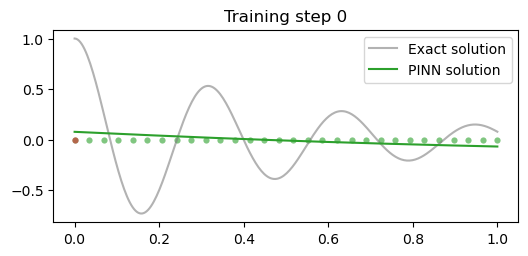

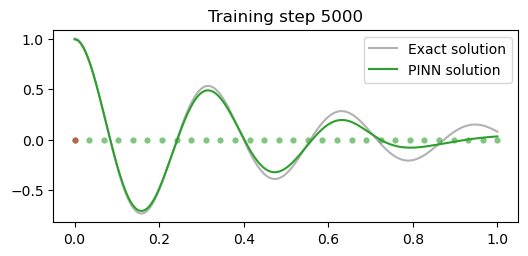

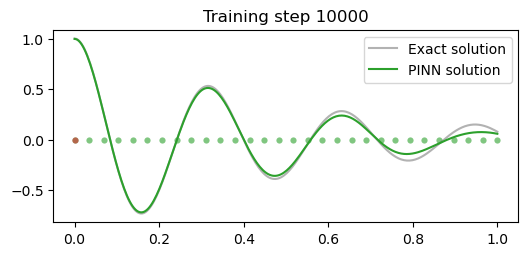

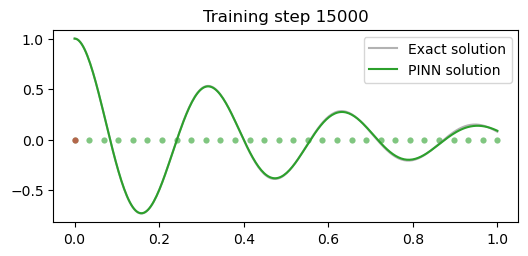

In [5]:

for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-4
    
    # compute boundary loss
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # compute physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

### Task 1 review

The results look very promising, with the PINN able to accurately simulate the system over the entire domain.

**Question**: why did we use `tanh` activation functions in the hidden layers of our NN?

## Task 2: train a PINN to invert for underlying parameters

The second task is to use a PINN to **invert** for underlying parameters. This is a common problem in the geosciences and environmental sciences, where we often have data but don't know the underlying parameters of the system.

Specifically, our inputs and outputs are:

- Inputs: noisy observations of the oscillator's displacement
- Outputs: estimate $\mu$, the coefficient of friction



#### Approach

Similar to above, the PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

The key idea here is to also treat $\mu$ as a **learnable parameter** when training the PINN - so that we both simulate the solution and invert for this parameter.


#### Loss function

The PINN is trained with a slightly different loss function:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + $$
$$
\frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$



There are two terms in the loss function here. The first is the **physics loss**, formed in the same way as above, which ensures the solution learned by the PINN is consistent with the know physics.



The second term is called the **data loss**, and makes sure that the solution learned by the PINN fits the (potentially noisy) observations of the solution that are available.




#### Loss function

Note, we have removed the boundary loss terms, as we do not know these (i.e., we are only given the observed measurements of the system).

In this set up, the PINN parameters $\theta$ and $\mu$ are **jointly** learned during optimisation.

Again, autodifferentiation is our friend and will allow us to easily define this problem!

True value of mu: 4


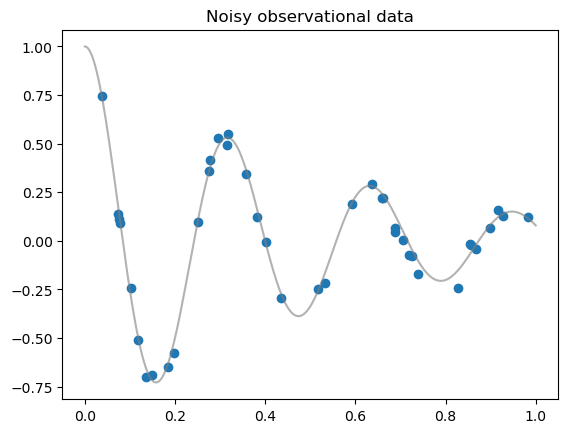

In [6]:
# first, create some noisy observational data
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

In [7]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
_, k = 2*d, w0**2

# treat mu as a learnable parameter
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

# add mu to the optimiser
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)

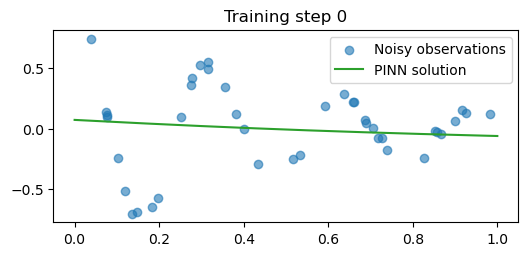

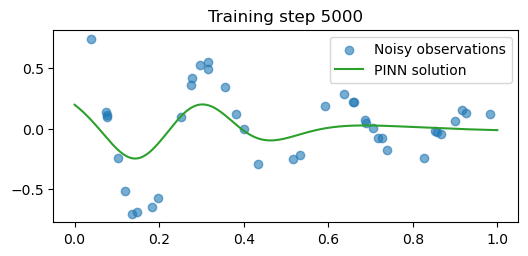

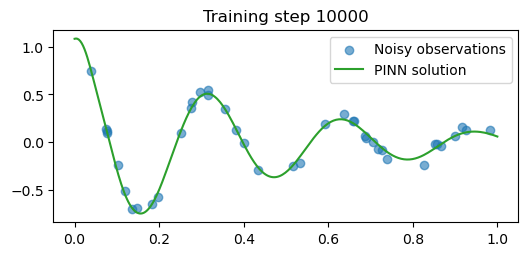

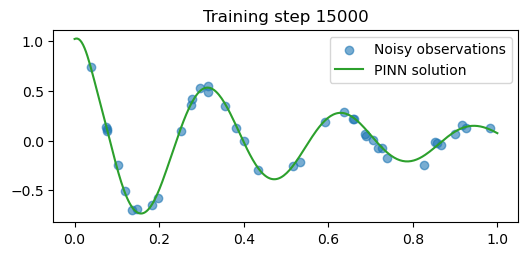

In [8]:
for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1 = 1e4
    
    # compute physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # compute data loss
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)
    
    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2
    loss.backward()
    optimiser.step()
    
    # record mu value
    mus.append(mu.item())
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

Let's look at how the estimate for $\mu$ changed over the training:

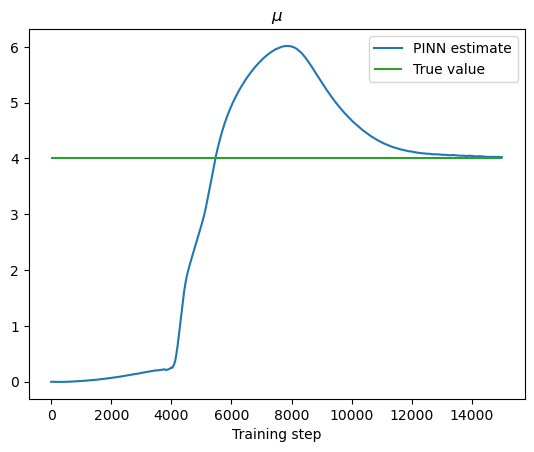

In [9]:
plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()